In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import loadmat
import random
import pandas as pd

import ERS_functions as ERS

In [25]:
#!!!! Read note in docstring below about re-RUNNING This script !!!!

# Defining parameters

student_number = 5381827
student_number = list(str(student_number))
for i in range(len(student_number)):
    student_number[i] = int(student_number[i])
A, B, C, D, E, F, G = student_number


#g = 9.81                    # Gravitational acceleration [m/s^2]
xi = 0.040 + C * 1e-3        # Damping ratio []
PGA = (0.33 + D * 1e-2)      # Peak ground acceleration [g]
gamma = 1.4                  # Importance factor [] - Importance class IV (assigned) corresponds to gamma=1.4 according to EN1998-1-1 (par 4.2.5)
a_g_ref = PGA*gamma
a_vg_ref = a_g_ref*0.45      #  - Type 2 Earthquake (M_s = 5.0, assigned parameter)



1.4074738247489391


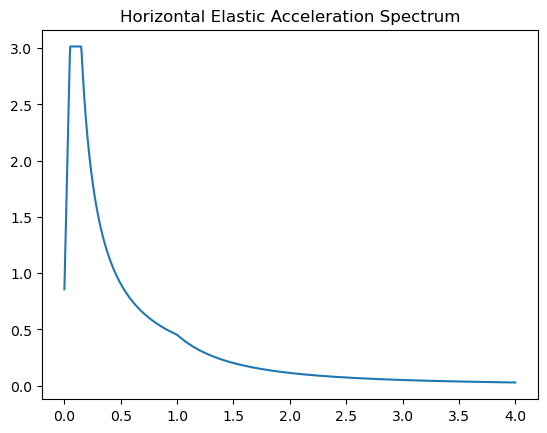

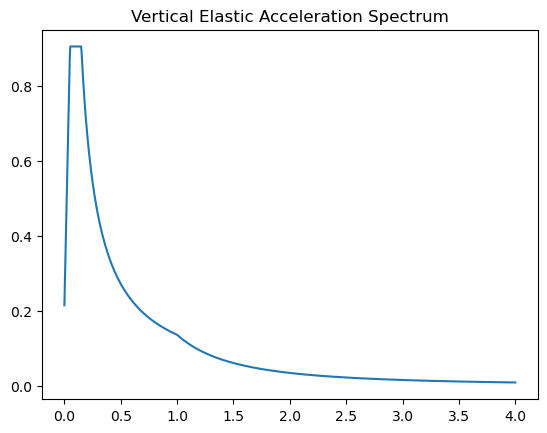

In [26]:

eta = np.sqrt(10/(5+xi))
print(eta) #Add eta check
S = 1.8
TB = 0.10
TC = 0.30
TD = 1.2
def horizontal_elastic_acc_spectrum(T, eta):
 Se_T_values = []
 for T in T:
   if 0 <= T <= TB:
      Se_T = a_g_ref * S * (1 + (T / TB) * (eta * 2.5 - 1))
      Se_T_values.append(Se_T)
   elif TB < T <= TC:
      Se_T = a_g_ref * S * eta * 2.5
      Se_T_values.append(Se_T)
   elif TC < T <= TD:
      Se_T = a_g_ref * S * eta * 2.5 * (TC / T)
      Se_T_values.append(Se_T)
   elif TD < T <= 4.0:
      Se_T = a_g_ref * S * eta * 2.5 * (TC * TD) / (T ** 2)
      Se_T_values.append(Se_T)
   else:
      Se_T = 0  # Or raise an exception or handle out-of-range T
      Se_T_values.append(Se_T)
 return Se_T_values


TB = 0.05 
TC = 0.15
TD = 1.0

def vertical_elastic_acceleration_response_spectrum(T, eta):
  Svd_T_values = []
  for T in T: 
      if 0 <= T <= TB:
           Svd_T = a_vg_ref * (1 + (T / TB) * (eta * 3.0 - 1))
           Svd_T_values.append(Svd_T)
      elif TB < T <= TC:
          Svd_T = a_vg_ref * eta * 3.0
          Svd_T_values.append(Svd_T)
      elif TC < T <= TD:
          Svd_T = a_vg_ref * eta * 3.0 * (TC / T)
          Svd_T_values.append(Svd_T)
      elif TD < T:
          Svd_T = a_vg_ref * eta * 3.0 * (TC * TD) / (T ** 2)
          Svd_T_values.append(Svd_T)
      else:
          Svd_T = 0  # Or handle as out-of-rang
          Svd_T_values.append(Svd_T)
  return Svd_T_values


T = np.linspace(0,4,1000)

plt.plot(T,horizontal_elastic_acc_spectrum(T,eta))
plt.title("Horizontal Elastic Acceleration Spectrum")
plt.show()

plt.plot(T,vertical_elastic_acceleration_response_spectrum(T,eta))
plt.title("Vertical Elastic Acceleration Spectrum")
plt.show()

In [27]:
'''
(c) TU Delft
This script will analyse all the accelerograms (x,y,z) direction and
construct their ERS based on a numerical calculation. The mean of the
horizontal and vertical acting accelerograms will be calculated as well
and will be saved to a .mat file. Furthermore, the signals will be
made RFEM ready and placed in a folder. 

!!!!!!!!!!!!!!!!!!!!!!
Please note that every time
this file runs, it will add the signal data to the existing files in
"Signals", therefore make sure that if you re-run this file you
delete those files.

At some locations you will find '<---- fill in equation', please fill in the
appropriate equation here to continue.
'''

# generate the random number to choose specific files
files = random.sample(range(8),5)
print('Chosen files are: ' + str(files))

## importing acclerograms and looping over them to create the ERS

# Determine scaling value:
gamma = gamma                           # (defined in parameter section) <------ fill in equation here
PGA = PGA                               # (defined in parameter section) <------ fill in equation here


# initialising loop
N = len(files)
SA_el_hor = np.zeros((201,2*N))
SA_el_ver = np.zeros((201,N))
ag_all = [None] * (3*N)
NPTS_all = np.zeros((N,))
Dt_all = np.zeros((N,))

## loops for reading files and decomposing in principal directions
jj = 0
for ifile in files:
    NPTS, Dt, ag_time = ERS.fnc_read_induced_signals(ifile)
    for ii in range(3):
        ag_all[3*jj+ii] = ag_time[ii]
    NPTS_all[jj] = NPTS
    Dt_all[jj] = Dt
    jj += 1
    
for iN in range(N):
    # get the file locations
    hor1 = 3*iN + 1 
    hor2 = 3*iN + 2
    ver = 3*iN + 3

    ag_1, ag_2 = ERS.fnc_calc_covariance(ag_all[hor1-1], ag_all[hor2-1], ag_all[ver-1], Dt_all[iN])
    ag_all[hor1-1] = ag_1 # store 1st principal hor. dir.
    ag_all[hor2-1] = ag_2 # store 2nd principal hor. dir.    

    
# loop for calculation response spectra and saving decomposed signals such that ZeusNL is able to use them

PGA_init = [None] * (3*N) 

for iN in range(1, N+1):
    # get the file locations
    hor1 = 3*(iN-1) + 0  
    hor2 = 3*(iN-1) + 1
    ver = 3*(iN-1) + 2
    for ifile in [hor1, hor2, ver]:
        # read the signal
        ag_time = ag_all[ifile]
        NPTS = NPTS_all[iN-1]
        Dt = Dt_all[iN-1]
        
        # In order to scale down the time history signal to a predifined PGA we 
        # have to:
        #   1) Find the initial PGA (absolute value) of the signal named after 
        #      "PGA_init" below; 
        #   2) We scale the signal such that PGA = PGA_max in case of the first and second principal hor. dir. 
        #      and the vertical one is scaled with the same ratio as the first principal hor. dir.
                
        PGA_init[ifile] = np.max(np.abs(ag_time))/(100*9.81)    #  (data is in cm/s^2) - convert to g
        
        if ifile != ver: 
            ag_time = PGA/PGA_init[ifile] * ag_time / (100*9.81) 
        else:
            ag_time = PGA/PGA_init[hor1] * ag_time / (100*9.81)  
        
        ## calculate the elastic response spectrum
        xi = xi                            # (defined in parameter section) <------ fill in equation here
        
        SA_el, Fel  =  ERS.fnc_Elastic_Response_Spectrum(ag_time, Dt, NPTS, xi)

        # determine in which array it should be stored
        if ifile == hor1:
            loc = 2*(iN-1) + 1
            name = 'hor1'
            SA_el_hor[:, loc-1] = SA_el
            ag_hor1 = ag_time * 9.81 # convert back to m/s2 for RFEM
        elif ifile == hor2:
            loc = 2*(iN-1) + 2
            name = 'hor2'
            SA_el_hor[:, loc-1] = SA_el
            ag_hor2 = ag_time * 9.81 # convert back to m/s2 for RFEM
        elif ifile == ver:
            loc = (iN-1) + 1
            name = 'ver'
            SA_el_ver[:, loc-1] = SA_el
            ag_vert = ag_time * 9.81 # convert back to m/s2 for RFEM
        
        ## Use the earthquake signal data to generate signals for ZeusNL for question 4
        t = np.linspace(0, len(ag_time)*Dt, len(ag_time))  # create time vector
        signal = np.vstack((t, ag_time)).T  # create signal matrix
        
        # save the file
        filename = f"Signal-{iN}-{name}.txt"
        savepath = 'Signals'
        os.makedirs(savepath, exist_ok=True)
        fileID = open(os.path.join(savepath, filename), 'at')
        np.savetxt(fileID, signal, fmt='%.6f')
        fileID.close()  # Close the file.  
        
    # Also save all signals in .xlsx format for RFEM
    df = pd.DataFrame({
        'Time [s]': t,
        'Horizontal 1 [g]': ag_hor1,
        'Horizontal 2 [g]': ag_hor2,
        'Vertical [g]': ag_vert,
    })
    
    # Save to .xlsx
    savepath = 'Signals'
    os.makedirs(savepath, exist_ok=True)
    filename = f"Signal-Set-{iN}.xlsx"
    df.to_excel(os.path.join(savepath, filename), index=False)

        
# create period vector
Tn = np.arange(0, 4.02, 0.02)

SA_el_hor1_mean = np.mean(SA_el_hor[:,0::2], axis=1) # mean value of principal hor. spectra
SA_el_hor2_mean = np.mean(SA_el_hor[:,1::2], axis=1) # mean value of hor. spectra
SA_el_ver_mean = np.mean(SA_el_ver, axis=1) # same as above but vertical

# Convert SA to m/s²
SA_el_hor1_mean_ms2 = SA_el_hor1_mean * 9.81
SA_el_hor2_mean_ms2 = SA_el_hor2_mean * 9.81
SA_el_ver_mean_ms2  = SA_el_ver_mean  * 9.81

# Frequency vector (avoid divide by zero)
f = np.zeros_like(Tn)
f[1:] = 1 / Tn[1:]  # skip Tn=0

# Save directory
savepath = 'ERS_Means'
os.makedirs(savepath, exist_ok=True)

# Helper to save a mean spectrum
def save_spectrum_to_excel(filename, SA_values):
    df = pd.DataFrame({
        'Tn': Tn,
        'f': f,
        'SA': SA_values
    })
    df.to_excel(os.path.join(savepath, filename), index=False, header=True)

# Save each
save_spectrum_to_excel("SA_el_hor1_mean.xlsx", SA_el_hor1_mean_ms2)
save_spectrum_to_excel("SA_el_hor2_mean.xlsx", SA_el_hor2_mean_ms2)
save_spectrum_to_excel("SA_el_ver_mean.xlsx",  SA_el_ver_mean_ms2)
        


Chosen files are: [0, 3, 5, 2, 1]


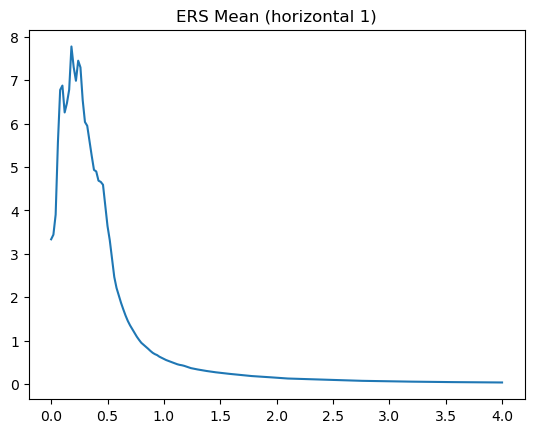

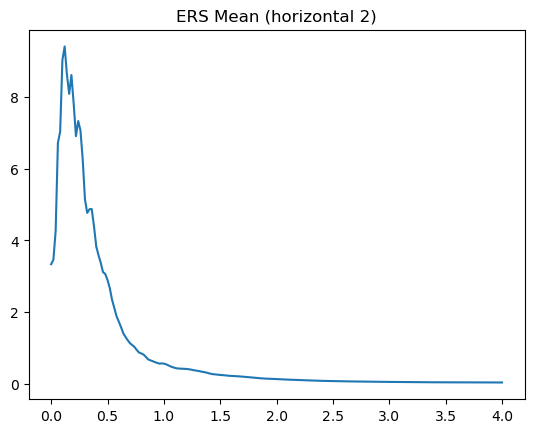

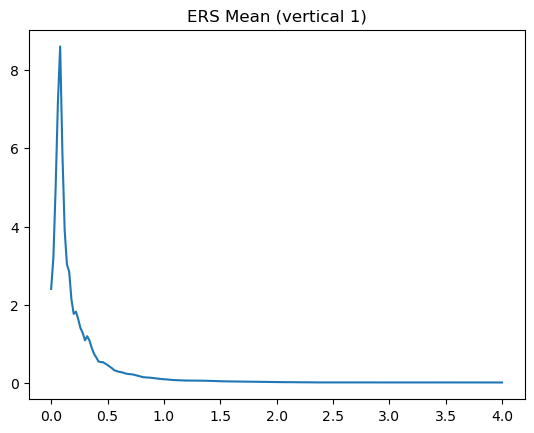

In [28]:
df_SA_el_hor_1 = pd.read_excel('ERS_Means/SA_el_hor1_mean.xlsx', engine='openpyxl')
df_SA_el_hor_2 = pd.read_excel('ERS_Means/SA_el_hor2_mean.xlsx', engine='openpyxl')
df_SA_el_ver = pd.read_excel('ERS_Means/SA_el_ver_mean.xlsx', engine='openpyxl')

plt.plot(df_SA_el_hor_1.iloc[:,0],df_SA_el_hor_1.iloc[:,2])
plt.title("ERS Mean (horizontal 1)")
plt.show()

plt.plot(df_SA_el_hor_2.iloc[:,0],df_SA_el_hor_2.iloc[:,2])
plt.title("ERS Mean (horizontal 2)")
plt.show()

plt.plot(df_SA_el_ver.iloc[:,0],df_SA_el_ver.iloc[:,2])
plt.title("ERS Mean (vertical 1)")
plt.show()

# Answer to Question 1b:
